## Midterm Project

#### Vishnupriya Santhosh (vs263)

In [5]:
# Importing the required libraries
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from tensorflow.keras import layers
import os
from sklearn.model_selection import *

In [6]:
np.random.seed(42)
%matplotlib inline

plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

In [7]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "digitrec"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#### Building the input pipeline

In [8]:
# Read the data
digit_read_train=pd.read_csv('C:/Users/16292/Vishnupriya/DeepLearning/digit-recognizer/train.csv')
digit_read_train.shape

(42000, 785)

In [9]:
#Extract the data and normalizing it
x_train = digit_read_train.drop(columns="label")
y_train = digit_read_train["label"]
X_train=x_train/255

In [10]:
#Labels
y_train.head() 

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [11]:
# Encoding labels into categories
Y_train = keras.utils.to_categorical(y_train, 10)
y_train[0]

1

In [12]:
y_train

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64

In [13]:
Y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [14]:
#Reshaping the training dataset to 
X_train = X_train.values.reshape(-1, 28, 28, 1)
print(X_train.shape)
print(Y_train.shape)

(42000, 28, 28, 1)
(42000, 10)


#### Splitting the dataset into test, train and validation datasets

In [15]:
X_train,X_part,Y_train,Y_part=train_test_split(X_train,Y_train,train_size=0.8,random_state=42)

In [16]:
X_valid, X_test, Y_valid, Y_test = train_test_split(X_part,Y_part, test_size=0.5)

In [17]:
X_train.shape

(33600, 28, 28, 1)

In [18]:
X_part.shape

(8400, 28, 28, 1)

In [19]:
Y_train.shape

(33600, 10)

In [20]:
Y_part.shape

(8400, 10)

In [21]:
X_valid.shape

(4200, 28, 28, 1)

In [22]:
X_test.shape

(4200, 28, 28, 1)

In [23]:
Y_valid.shape

(4200, 10)

In [24]:
Y_test.shape

(4200, 10)

#### The Sample Dataset

Saving figure digit_data_plot


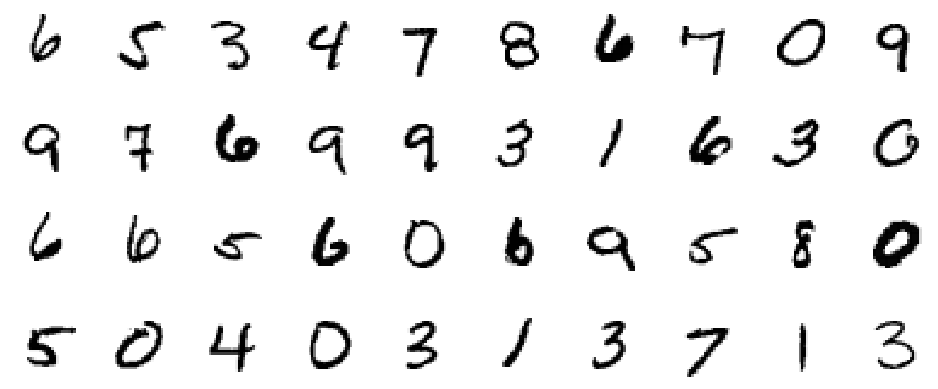

In [25]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('digit_data_plot', tight_layout=False)
plt.show()

#### Custom Activation Functions, Initializers and Constraints

In [26]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1

alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [27]:
def softplus_func(a):
    return tf.math.log(tf.exp(a) + 1)

In [28]:
def glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

In [29]:
def l1_regularizerfunc(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

In [30]:
def positive_weightsfunc(weights):
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [31]:
def standardization_func(tensor):
    means = tf.math.reduce_mean(tensor, axis=None, keepdims=True, name=None)
    stds = tf.math.reduce_std(tensor, axis=None, keepdims=True, name=None)
    eps = keras.backend.epsilon()
    return ((tensor - means) / (stds + eps))

#### Building the model without the CNN
* Flatten the inputs and pass it on to a fully connected dense layer, using SELU activation function and 'Lecun Normal' Kernel Initializer. 
* Before passing it on to a PRELU layer, add a lambda layer to standardize and transform the input features. 
* Add the dense layer and use the customised activation function, regularizer, initializer and constraints. 
* Finally, add an output layer of 10 units for representing 10 digit classes using the softmax activation function.

In [28]:
model = tf.keras.Sequential()
input_ = layers.Input(shape=(28,28,1), name="input_")
input_flatten = layers.Flatten()(input_)
denselayer_1 = layers.Dense(units=80, activation="selu", kernel_initializer='lecun_normal')(input_flatten)
lambda_layer = layers.Lambda(standardization_func, name="lambda_layer")(denselayer_1)
prelu_layer = layers.PReLU()(lambda_layer)
denselayer_2 = layers.Dense(1, activation=softplus_func,
                       kernel_initializer=glorot_initializer,
                       kernel_regularizer=l1_regularizerfunc,
                       kernel_constraint=positive_weightsfunc)(prelu_layer)
output_layer = layers.Dense(10,activation="softmax")(denselayer_2)

In [29]:
model = tf.keras.models.Model(input_, output_layer, name="model")

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 80)                62800     
                                                                 
 lambda_layer (Lambda)       (None, 80)                0         
                                                                 
 p_re_lu (PReLU)             (None, 80)                80        
                                                                 
 dense_1 (Dense)             (None, 1)                 81        
                                                                 
 dense_2 (Dense)             (None, 10)                20    

In [31]:
# Compile the Model
model.compile(loss="categorical_crossentropy",optimizer= keras.optimizers.SGD(learning_rate=1e-3),
              metrics=['accuracy'])

In [32]:
history_train=model.fit(X_train,Y_train,epochs=90,validation_data=(X_valid,Y_valid))


Epoch 1/90
1050/1050 [==============================] - 7s 6ms/step - loss: 2.4068 - accuracy: 0.0961 - val_loss: 2.3693 - val_accuracy: 0.0936
Epoch 2/90
1050/1050 [==============================] - 5s 5ms/step - loss: 2.3434 - accuracy: 0.0961 - val_loss: 2.3348 - val_accuracy: 0.0936
Epoch 3/90
1050/1050 [==============================] - 6s 5ms/step - loss: 2.3089 - accuracy: 0.0961 - val_loss: 2.2982 - val_accuracy: 0.0936
Epoch 4/90
1050/1050 [==============================] - 6s 5ms/step - loss: 2.2696 - accuracy: 0.0935 - val_loss: 2.2565 - val_accuracy: 0.0876
Epoch 5/90
1050/1050 [==============================] - 6s 5ms/step - loss: 2.2250 - accuracy: 0.0831 - val_loss: 2.2095 - val_accuracy: 0.0745
Epoch 6/90
1050/1050 [==============================] - 6s 5ms/step - loss: 2.1775 - accuracy: 0.0876 - val_loss: 2.1623 - val_accuracy: 0.1107
Epoch 7/90
1050/1050 [==============================] - 6s 5ms/step - loss: 2.1346 - accuracy: 0.1461 - val_loss: 2.1226 - val_accuracy:

#### Accuracy Evaluation and Learning Curves

In [33]:
accuracy=model.evaluate(X_test,Y_test)

132/132 [==============================] - 1s 4ms/step - loss: 1.6137 - accuracy: 0.3460


##### Attained an accuracy of only 34.60%

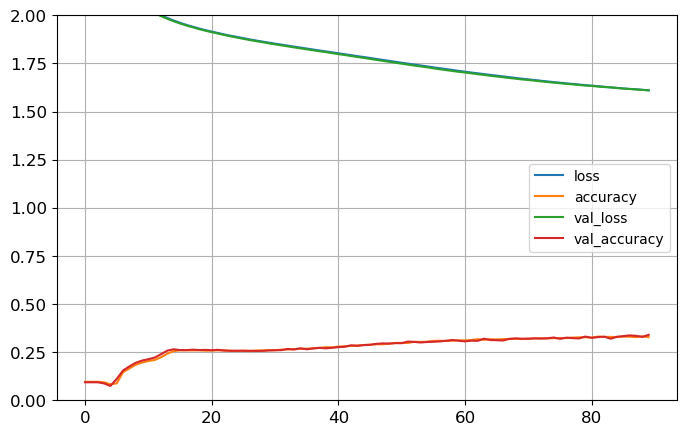

In [34]:
pd.DataFrame(history_train.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

#### Building a model with CNN
* Build a better model using CNN in an attempt to increase the accuracy and efficiency
* Convolution layers with MaxPooling layers are added and output layer used alongwith a SoftMax activation function

In [32]:
cnn_model = tf.keras.Sequential()
input_ = layers.Input(shape=(28,28,1), name="input_")
cnn_1 = layers.Conv2D(64, 7, activation='relu', padding='same')(input_)
mp_1 = layers.MaxPooling2D(2)(cnn_1)
cnn_2 = layers.Conv2D(128, 3, activation='selu', padding='same')(mp_1)
cnn_3 = layers.Conv2D(128, 3, activation='selu', padding='same')(cnn_2)
mp_2 = layers.MaxPooling2D(2)(cnn_3)
cnn_4 = layers.Conv2D(256, 3, activation='selu', padding='same')(mp_2)
cnn_5 = layers.Conv2D(256, 3, activation='selu', padding='same')(cnn_4)
mp_3 = layers.MaxPooling2D(2)(cnn_5)
cnn_6 = layers.Conv2D(512, 3, activation='selu', padding='same')(mp_3)
cnn_7 = layers.Conv2D(512, 3, activation='selu', padding='same')(cnn_6)
mp_4 = layers.MaxPooling2D(2)(cnn_7)
cnn_8 = layers.Conv2D(1024, 3, activation='selu', padding='same')(mp_4)
flatten_layer = layers.Flatten()(cnn_8)
output_layer = layers.Dense(10,activation="softmax")(flatten_layer)

In [33]:
cnn_model = tf.keras.models.Model(input_, output_layer, name="cnn_model")

In [34]:
cnn_model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                     

In [35]:
# Compile the Model
cnn_model.compile(loss="categorical_crossentropy",optimizer='sgd',metrics=['accuracy'])

In [36]:
history_modelcnn =cnn_model.fit(X_train,Y_train,epochs=2,validation_data=(X_valid,Y_valid))

Epoch 1/2
1050/1050 [==============================] - 1373s 1s/step - loss: 0.4044 - accuracy: 0.8747 - val_loss: 0.1068 - val_accuracy: 0.9664
Epoch 2/2
1050/1050 [==============================] - 1344s 1s/step - loss: 0.0826 - accuracy: 0.9740 - val_loss: 0.0717 - val_accuracy: 0.9795


#### Accuracy Evaluation and Learning Curves

In [37]:
accuracy=cnn_model.evaluate(X_test,Y_test)

132/132 [==============================] - 14s 105ms/step - loss: 0.0666 - accuracy: 0.9802


##### Attained an accuracy of 98.02%

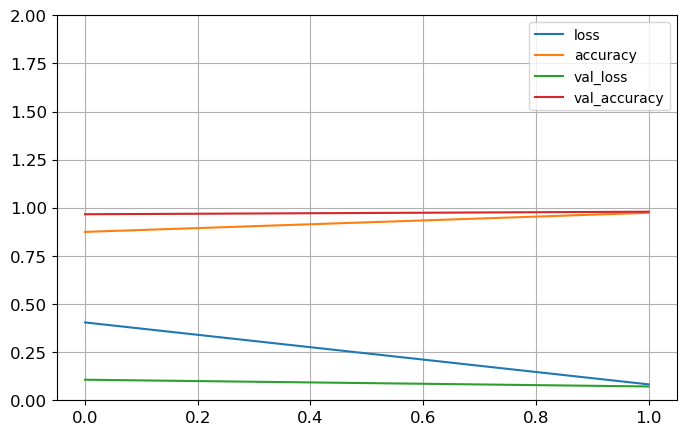

In [38]:
pd.DataFrame(history_modelcnn.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

#### Conclusion
* Here we observe that the accuracy obtained by using a CNN is 98.02% which is much higher than the normal dense networks
* The CNN converged to a better accuracy with fairly lesser number of epochs than the normal networks
* Hence, CNNs are much more preferred